In [1]:
%load_ext autoreload
%autoreload 2
from audiolib import AudioDataset

In [2]:
# Load guitar audio
test = AudioDataset('../data/raw/nsynth-test')
guitar = test.load_file(instrument='guitar_acoustic', file_index=6)
# Load piano audio
train = AudioDataset('../data/raw/nsynth-train')
piano = train.load_file(instrument='keyboard_acoustic', file_index=27)

In [3]:
# Functions
def boxprint(s):
    """Print string surrounded by lines"""
    l = '-' * len(s)
    print(f'{l}\n{s}\n{l}')

# 1. Spectrogram analysis<a id='spectrogram'></a>

The nylon guitar tone:
- Is composed of harmonic sine waves with decaying amplitude
- Has additional energy in the frequency band below the fundamental frequency (see [section 2](#filter)). These lower frequencies don't have any harmonics themselves.

The grand piano tone:
- Is composed of harmonic sine waves, as well as many powerful non-harmonic frequencies

- Has more energy around the 3rd and 4th harmonics than the fundamental (see [section 2](#filter)). These higher frequencies don't have any harmonics themselves.

In [4]:
def spectrogram_analysis(audiofile, params):
    for p in params:
        boxprint(p['print'])
        # Load and play audio
        audiofile.reload()
        audio = audiofile.audio.trim(p['start'], p['end'])
        audio.plot()
        print('- original sound:')
        audio.play()
        # Create spectrogram and reconstruct audio
        spectrogram = audio.to_spectrogram(time_intervals=p['time_intervals'])
        spectrogram.plot(db_thresh=p['db_thresh'], fmax=-1, title=p['title'])
        print('- reconstructed sound:')
        spectrogram.to_audio().play()

## Guitar

--------------
Guitar attack:
--------------


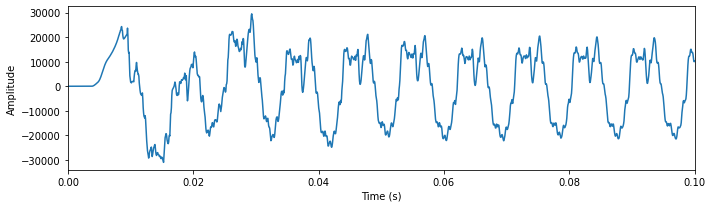

- original sound:


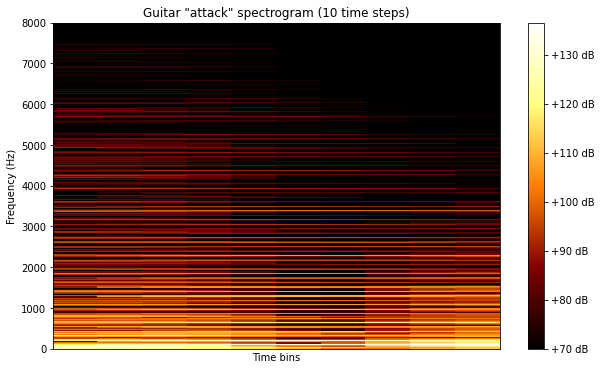

- reconstructed sound:


---------------
Guitar sustain:
---------------


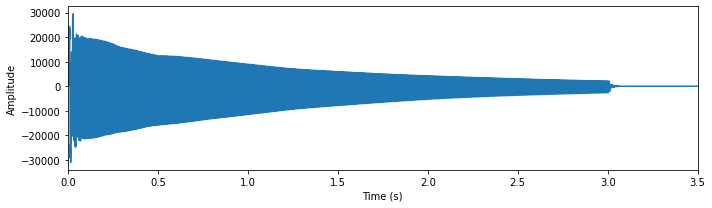

- original sound:


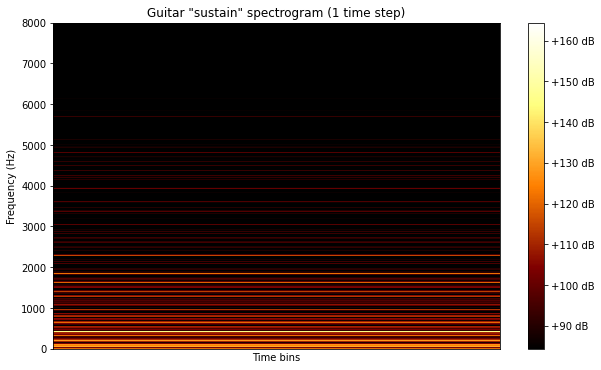

- reconstructed sound:


In [5]:
# Guitar
guitar_params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'db_thresh': 70,
     'print': 'Guitar attack:', 'title': 'Guitar "attack" spectrogram (10 time steps)'},
    {'start': 0, 'end': 3.5, 'time_intervals': 1, 'db_thresh': 70,
     'print': 'Guitar sustain:', 'title': 'Guitar "sustain" spectrogram (1 time step)'}
]
spectrogram_analysis(guitar, guitar_params)

## Piano

-------------
Piano attack:
-------------


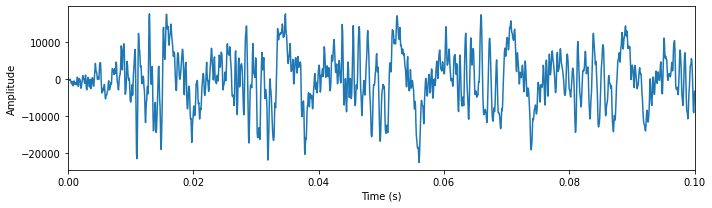

- original sound:


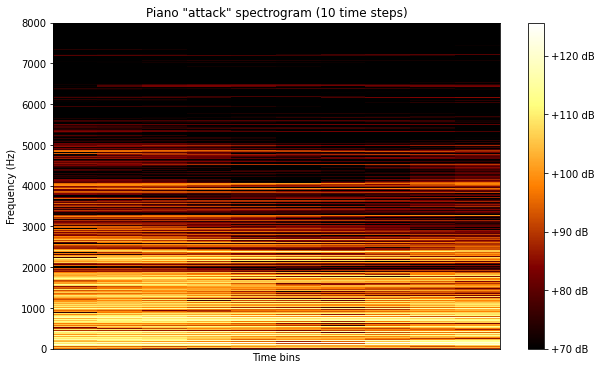

- reconstructed sound:


--------------
Piano sustain:
--------------


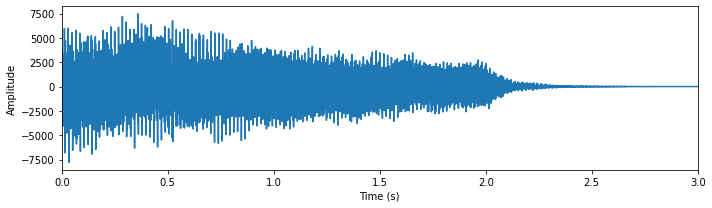

- original sound:


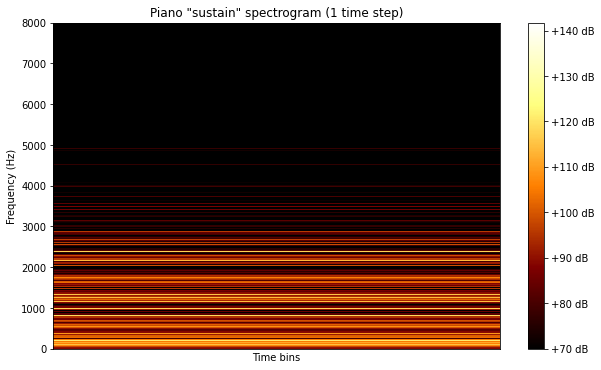

- reconstructed sound:


In [6]:
# Piano
piano_params = [
    {'start': 0, 'end': 0.1, 'time_intervals': 10, 'db_thresh': 70, 'max_freq': -1,
     'print': 'Piano attack:', 'title': 'Piano "attack" spectrogram (10 time steps)'},
    {'start': 1, 'end': 4, 'time_intervals': 1, 'db_thresh': 70, 'max_freq': -1,
     'print': 'Piano sustain:', 'title': 'Piano "sustain" spectrogram (1 time step)'}
]
spectrogram_analysis(piano, piano_params)

# 2. Post-filter analysis<a id='filter'></a>

After applying a lowpass filter which removes frequencies above the 2nd harmonic:

- The guitar sounds roughly the same (just a lowpass version)
- The piano sounds very different (almost like the guitar now)


This shows that:

- The guitar tone has a lot of energy in its lower harmonics
- The piano tone has a lot of energy in its upper harmonics

In [7]:
def filter_analysis(audiofile, start, end, db_thresh, instr_name=''):
    audiofile.reload()
    audio = audiofile.audio.trim(start, end)

    print('No filter:')
    # Plot and play audio
    audio.plot()
    audio.play()
    # Create spectrogram and plot
    spectrogram = audio.to_spectrogram()
    spectrogram.plot(db_thresh, axis_harm=True,
                     title=f'{instr_name} "sustain" spectrogram (no filter)')

    print('Low-pass filter:')
    # Apply lowpass filter and play audio
    filtered_audio = audio.filter(0, 2*audio.fundamental_freq, 'lowpass')
    filtered_audio.plot()
    filtered_audio.play()
    # Create spectrogram and plot
    filtered_spectrogram = filtered_audio.to_spectrogram()
    filtered_spectrogram.plot(db_thresh, axis_harm=True,
                              title=f'{instr_name} "sustain" spectrogram (220hz low-pass filter)')

## Guitar

No filter:


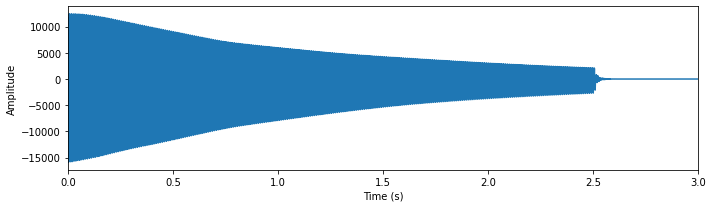

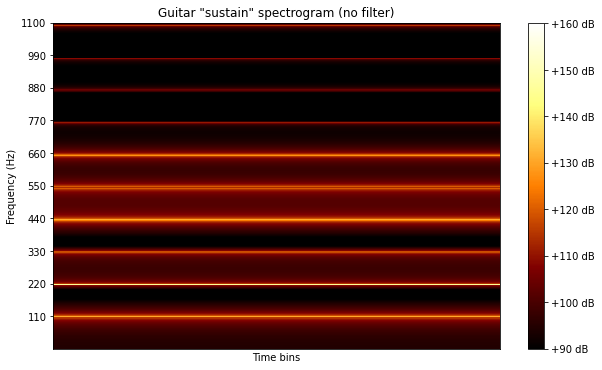

Low-pass filter:


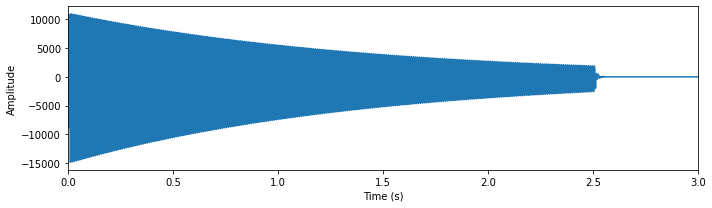

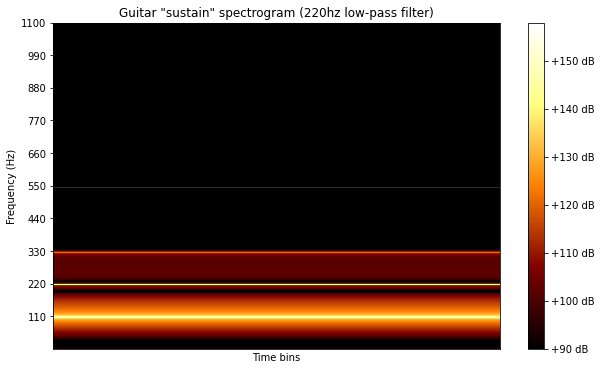

In [8]:
filter_analysis(guitar, start=0.5, end=3.5, db_thresh=90, instr_name='Guitar')

## Piano

No filter:


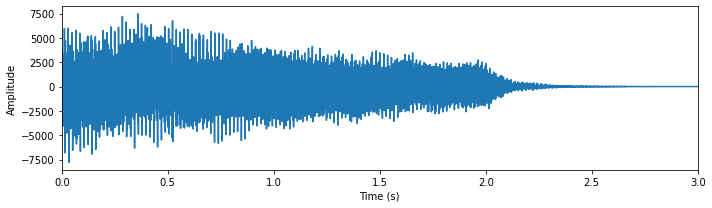

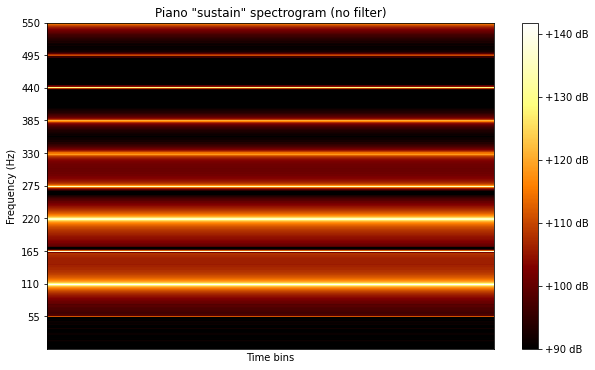

Low-pass filter:


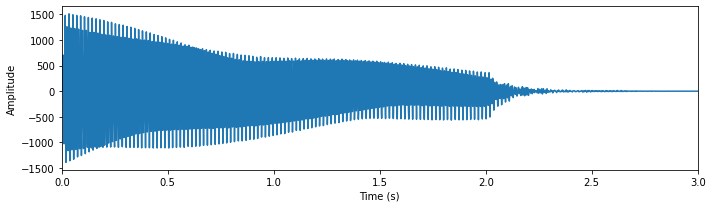

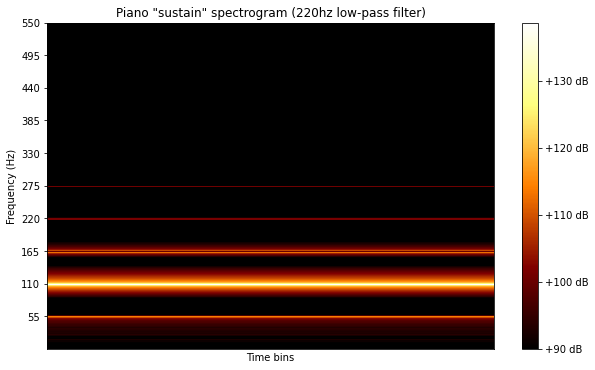

In [9]:
filter_analysis(piano, start=1, end=4, db_thresh=90, instr_name='Piano')

# 3. Harmonics analysis<a id='harmonics'></a>

Removing all frequencies except the harmonics of the fundamental frequency:

- The guitar sounds roughly the same (just a bit more like a pure sine-wave oscillator)
- The piano sounds very different (kind of like a chime or square wave)


This shows that:

- The guitar tone has a lot of energy in the harmonics themselves
- The piano tone has a lot of energy in the frequencies around its harmonics

N.B. Setting the same amplitude to all of the harmonics (0dB - maximum) sounds like a sawtooth wave. This demonstrates that the relative amplitudes of the harmonics has an important role in determining the final sound.

In [10]:
def harmonics_analysis(audiofile, start, end, db_thresh, instr_name, neighbour_radius=4):
    # Load audio
    audiofile.reload()
    audio = audiofile.audio.trim(start=0.5, end=3.5)

    print('All frequencies:')
    # Create and plot spectrogram
    spectrogram = audio.to_spectrogram(mode='fast')
    spectrogram.plot(db_thresh, axis_harm=True,
                     title=f'{instr_name} "sustain" spectrogram (all frequencies)')
    spectrogram.to_audio().play()

    print('Harmonics only:')
    # Create spectrogram which only contains the harmonics
    spectrogram_harm = spectrogram.filter_harmonics(neighbour_radius)
    spectrogram_harm.plot(axis_harm=True,
                          title=f'{instr_name} "sustain" spectrogram (harmonics only)')
    spectrogram_harm.to_audio().play()

## Guitar

All frequencies:


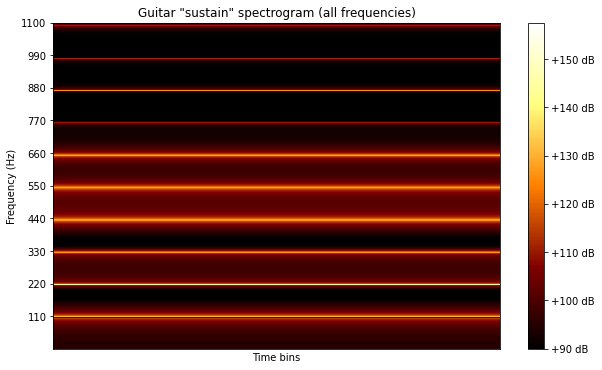

Harmonics only:


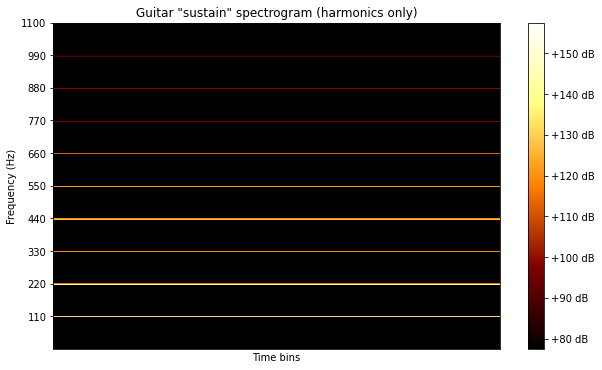

In [11]:
harmonics_analysis(guitar, start=0.5, end=3.5, db_thresh=90, instr_name='Guitar',
                   neighbour_radius=4)

## Piano

All frequencies:


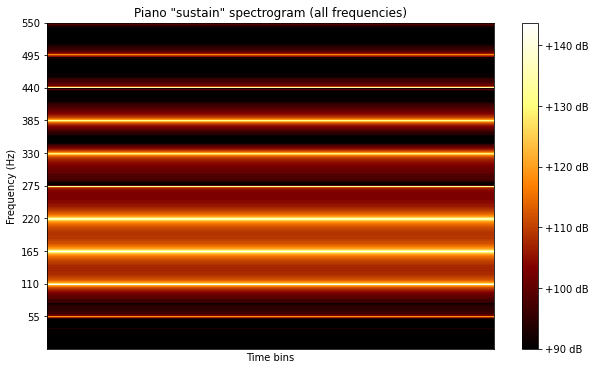

Harmonics only:


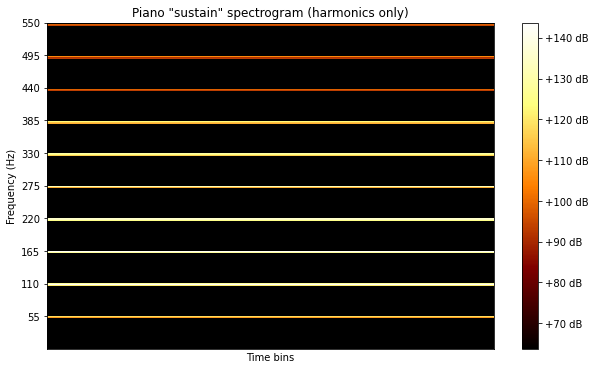

In [13]:
harmonics_analysis(piano, start=0.5, end=3.5, db_thresh=90, instr_name='Piano',
                   neighbour_radius=4)

# 4. Log scale<a id='log'></a>

This representation will be used for modeling, since it more-or-less preserves the shape of the spectrogram across the frequency axis, no matter which note is played on the instrument

In [14]:
def cqt_analysis(audiofile, start, end, db_thresh, instr_name, resolution=40):
    # Load audio
    audiofile.reload()
    audio = audiofile.audio.trim(start, end)

    print('Linear scale:')
    # Load audio and create spectrogram
    spectrogram = audio.to_spectrogram()
    spectrogram.plot(db_thresh, axis_harm=True,
                     title=f'{instr_name} "sustain" spectrogram (linear scale)')
    spectrogram.to_audio().play()

    print('Log scale:')
    # Create spectrogram on log scale
    spectrogram_cqt = audio.to_spectrogram(resolution=resolution, cqt=True)
    spectrogram_cqt.plot(db_thresh, axis_harm=10,
                         title=f'{instr_name} "sustain" spectrogram (log2 scale)')
    spectrogram_cqt.to_audio().play()

## Guitar

Linear scale:


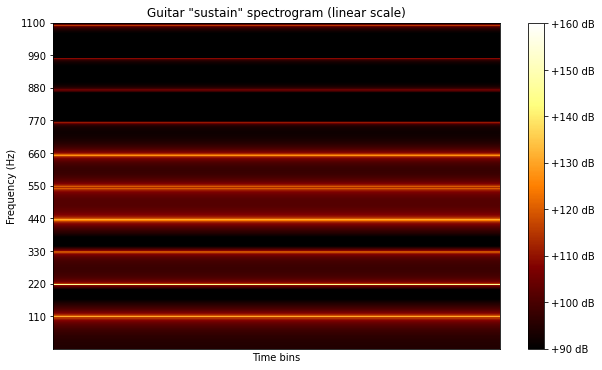

Log scale:


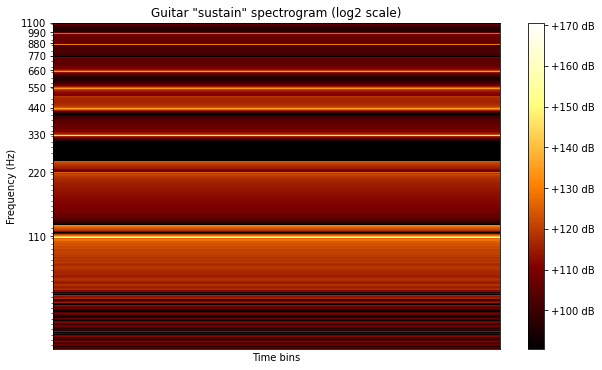

/home/julian/projects/deep-music/.venv/lib/python3.8/site-packages/librosa/core/constantq.py:673: UserWarning: hop_length=48000 exceeds minimum CQT filter length=1387.172.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  warnings.warn('hop_length={} exceeds minimum CQT filter length={:.3f}.\n'


In [15]:
cqt_analysis(guitar, start=0.5, end=3.5, db_thresh=90, instr_name='Guitar', resolution=40)

## Piano

Linear scale:


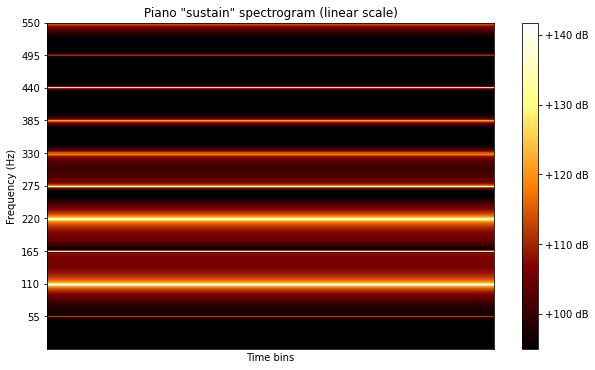

Log scale:


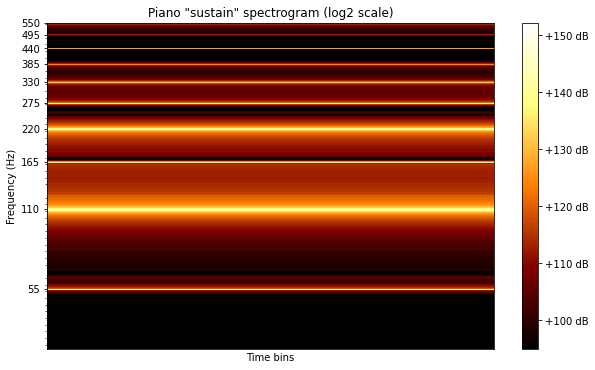

/home/julian/projects/deep-music/.venv/lib/python3.8/site-packages/librosa/core/constantq.py:673: UserWarning: hop_length=48000 exceeds minimum CQT filter length=1387.172.
This will probably cause unpleasant acoustic artifacts. Consider decreasing your hop length or increasing the frequency resolution of your CQT.
  warnings.warn('hop_length={} exceeds minimum CQT filter length={:.3f}.\n'


In [16]:
cqt_analysis(piano, start=1, end=4, db_thresh=95, instr_name='Piano', resolution=40)